In [35]:
import pandas as pd

df = pd.read_json('../datasets/7_dataset_SM.json')
df = df[:5000]
df = df.fillna(method='ffill')

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(oov_token="<OOV>")

In [37]:
df = df.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Dep', 'Polarity', 'Gender'].agg(lambda x: list(x))

C:\Users\hanse\AppData\Local\Temp/ipykernel_8504/1510606078.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Dep', 'Polarity', 'Gender'].agg(lambda x: list(x))


In [38]:
df

,Sentence #,Word,Lemma,POS,Dep,Polarity,Gender
0,1,"[organizations, decided, drop, women, accused,...","[organization, decide, drop, woman, accuse, in...","[NOUN, VERB, VERB, NOUN, VERB, ADJ, NOUN, ADJ,...","[nsubj, ROOT, xcomp, nsubj, advcl, amod, pobj,...","[-0.19334491413051003, -0.034137248164741, -0....","[W, W, W, W, W, W, W, W, W]"
1,2,"[Women, previously, worked, winning, actor, to...","[woman, previously, work, win, actor, tell, CN...","[NOUN, ADV, VERB, VERB, NOUN, VERB, PROPN, ADV...","[nsubj, advmod, relcl, amod, pobj, ROOT, dobj,...","[0.35316112487835105, -0.039333311401716003, -...","[W, W, W, W, W, W, W, W, W, W, W, W, W, W, W]"
2,3,"[response, allegations, Visa, announced, suspe...","[response, allegation, Visa, announce, suspend...","[NOUN, NOUN, PROPN, VERB, VERB, NOUN, NOUN]","[pobj, pobj, nsubj, ROOT, ccomp, compound, pobj]","[-0.039620517765398, -0.01715489752247, -0.023...","[W, W, W, W, W, W, W]"
3,4,"[aware, allegations, Mr.]","[aware, allegation, Mr.]","[ADJ, NOUN, PROPN]","[acomp, pobj, compound]","[-0.035281092794016006, -0.01715489752247, -0....","[W, W, W]"
4,5,"[point, Visa, suspending, marketing, actor, fe...","[point, Visa, suspend, marketing, actor, featu...","[NOUN, PROPN, VERB, NOUN, NOUN, VERB, PROPN, V...","[pobj, nsubj, ccomp, dobj, nsubjpass, relcl, n...","[-0.19485058785637502, -0.023234042885702, -0....","[W, W, W, W, W, W, W, W, W]"
...,...,...,...,...,...,...,...
487,587,"[Check, highlights, beginning, 1:20, clip]","[check, highlight, begin, 1:20, clip]","[VERB, NOUN, VERB, NUM, NOUN]","[ROOT, dobj, acl, pobj, pobj]","[0.13395629431782202, -0.041961959063024, -0.0...","[M, M, M, M, M]"
488,588,"[right, conditioning, fight, coach, thrown, to...","[right, conditioning, fight, coach, throw, tow...","[ADJ, NOUN, VERB, NOUN, VERB, NOUN, ADJ, ADJ, ...","[amod, dobj, relcl, nsubj, ccomp, pobj, amod, ...","[-0.08494815701551901, -0.0009555807142420001,...","[M, M, M, M, M, M, M, M, M, M, M]"
489,589,"[think, coach, let]","[think, coach, let]","[VERB, NOUN, VERB]","[ROOT, nsubj, ccomp]","[-0.076708684196439, -0.194677775887752, -0.03...","[M, M, M]"
490,590,[sad],[sad],[ADJ],[acomp],[-0.00039390346295100004],[M]


In [39]:
split = round(len(df)*0.8)
train_sentences = df['Lemma'][:split]
train_labels = df['Gender'][:split]
test_sentences = df['Lemma'][split:]
test_labels = df['Gender'][split:]

In [40]:
import numpy as np
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []

for row in train_labels:
    training_labels.append(0 if row[0] == 'M' else 1)
for row in test_labels:
    testing_labels.append(0 if row[0] == 'M' else 1)

In [41]:
vocab_size = 40000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [42]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

In [43]:
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

In [44]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 16)           640000    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 640,109
Trainable params: 640,109
Non-trainable params: 0
_________________________________________________________________


In [50]:
import numpy as np

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
num_epochs = 40
history = model.fit(padded, training_labels_final, epochs=num_epochs, 
validation_data=(testing_padded, testing_labels_final))

Epoch 1/40
13/13 [==============================] - 1s 16ms/step - loss: 0.6885 - accuracy: 0.5964 - val_loss: 0.6803 - val_accuracy: 0.6633
Epoch 2/40
13/13 [==============================] - 0s 7ms/step - loss: 0.6842 - accuracy: 0.5964 - val_loss: 0.6718 - val_accuracy: 0.6633
Epoch 3/40
13/13 [==============================] - 0s 9ms/step - loss: 0.6800 - accuracy: 0.5964 - val_loss: 0.6648 - val_accuracy: 0.6633
Epoch 4/40
13/13 [==============================] - 0s 8ms/step - loss: 0.6764 - accuracy: 0.5964 - val_loss: 0.6599 - val_accuracy: 0.6633
Epoch 5/40
13/13 [==============================] - 0s 6ms/step - loss: 0.6739 - accuracy: 0.5964 - val_loss: 0.6569 - val_accuracy: 0.6633
Epoch 6/40
13/13 [==============================] - 0s 7ms/step - loss: 0.6728 - accuracy: 0.5964 - val_loss: 0.6528 - val_accuracy: 0.6633
Epoch 7/40
13/13 [==============================] - 0s 6ms/step - loss: 0.6711 - accuracy: 0.5964 - val_loss: 0.6508 - val_accuracy: 0.6633
Epoch 8/40
13/13 [=

<Figure size 432x288 with 0 Axes>

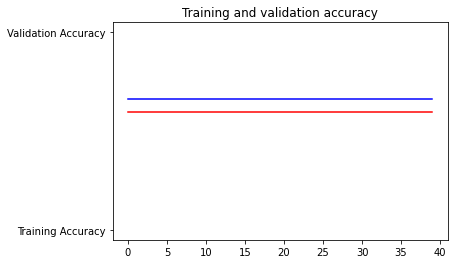

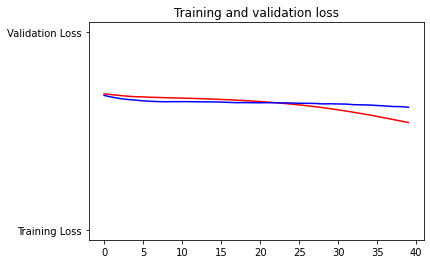

<Figure size 432x288 with 0 Axes>

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

In [48]:
test = tokenizer.texts_to_sequences('this is a test')
test = pad_sequences(test, maxlen=max_length)

test

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [49]:
samples = ['The plot is fantastic', 
    'The movie was cool and thrilling', 
    'one of the worst films I have ever seen']

# encode into integers
sample_encoded = [encoder.encode(sample) for sample in samples]

# pad with zeros to have same length 
sample_padded = []
for s in sample_encoded:
pad_length = 128 - len(s)
zeros = [0]*pad_length
s.extend(zeros)
s = tf.convert_to_tensor(s)
sample_padded.append(s)
# convert into tensor before feeding the model
sample_padded = tf.convert_to_tensor(sample_padded)

#make predictions
predictions = model.predict(sample_padded)
predictions

IndentationError: expected an indented block (Temp/ipykernel_8504/4207814905.py, line 11)